In [1]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import os
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore', ConvergenceWarning)

import pandas as pd
import numpy as np

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 9)
mpl.rcParams['axes.grid'] = True

from datetime import datetime
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy.optimize import curve_fit
from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

## Plot data

In [2]:
def plot_series(x, y, title, labels):

    fig = go.Figure()
    
    for i in range(len(y)):
        fig.add_trace(go.Scatter(x=x, y=y[i], name=labels[i]))

    fig.update_layout(
        title=title,
        margin=dict(l=60, r=40, t=80, b=40),
        height=600,
    )

    fig.show()

In [3]:
def plot_data(x, y, labels, title=None, xlabel="Dates", ylabel="Closing Prices ($)"):
    plt.figure()
    for i in range(len(x)):
        plt.plot(x[i], y[i], label=labels[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()    
    plt.show()

# Read data and data preparation

In [4]:
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('NFLX.csv', parse_dates=['Date'], date_parser=dateparse)
print("------------------------------------------------------------------------------")
print(data.info())
print("------------------------------------------------------------------------------")
print(data.describe())
print("------------------------------------------------------------------------------")

------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4874 entries, 0 to 4873
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4874 non-null   datetime64[ns]
 1   Open       4874 non-null   float64       
 2   High       4874 non-null   float64       
 3   Low        4874 non-null   float64       
 4   Close      4874 non-null   float64       
 5   Adj Close  4874 non-null   float64       
 6   Volume     4874 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 266.7 KB
None
------------------------------------------------------------------------------
              Open         High          Low        Close    Adj Close  \
count  4874.000000  4874.000000  4874.000000  4874.000000  4874.000000   
mean    104.644811   106.243736   103.006660   104.686524   104.686524   
std     155.886

In [5]:
data = data.drop(columns=["Open", "Low", "High", "Adj Close", "Volume"])
display(data)

,Date,Close
0,2002-05-23,1.196429
1,2002-05-24,1.210000
2,2002-05-28,1.157143
3,2002-05-29,1.103571
4,2002-05-30,1.071429
...,...,...
4869,2021-09-24,592.390015
4870,2021-09-27,592.640015
4871,2021-09-28,583.849976
4872,2021-09-29,599.059998


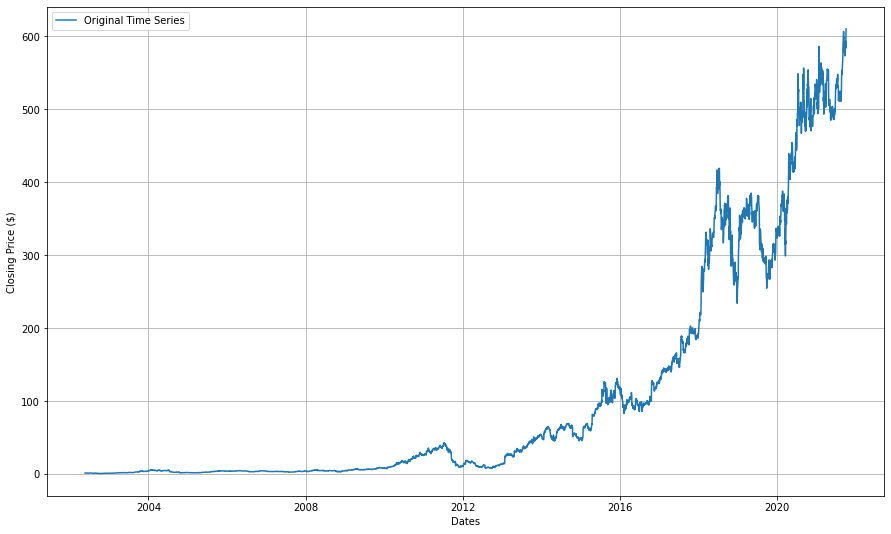

In [6]:
x, y = data["Date"], data["Close"]

plt.plot(x, y, label="Original Time Series")
plt.xlabel("Dates")
plt.ylabel("Closing Price ($)")
plt.legend()
plt.show()

293


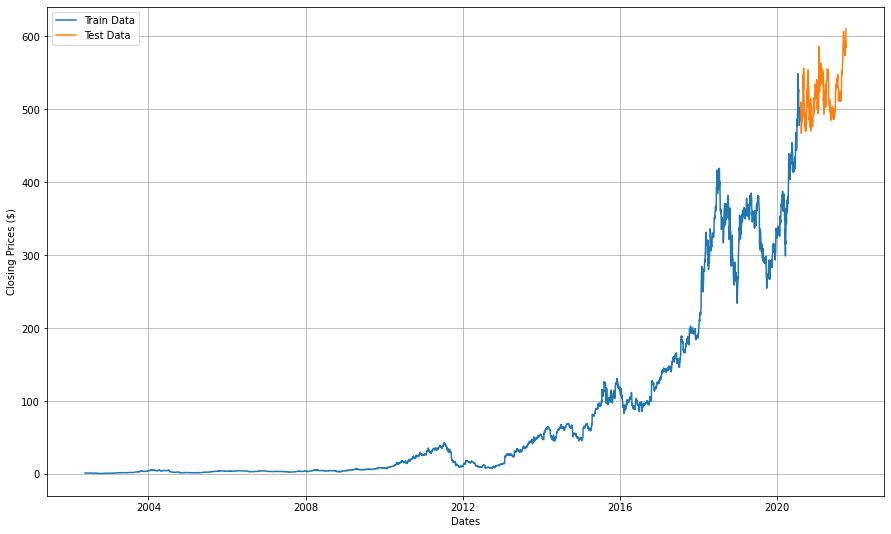

In [7]:
train_data, test_data = np.split(data, [int(.94 * len(data))])

X_train, y_train = train_data["Date"], train_data["Close"]
X_test, y_test = test_data["Date"], test_data["Close"]

print(len(X_test))

plot_data(
    [X_train, X_test],
    [y_train, y_test],
    ["Train Data", "Test Data"]
)

# Trend estimation (polinomial fit)

In [8]:
def estimation(x, y, deg, name):
    coefs = np.polyfit(x, y, deg)
    vals = np.polyval(coefs, x)
    TS = pd.Series(data=vals, index=x, name=name)
    return TS

MSE linear estimation: 8316.528
MSE quadatric estimation: 1698.974
MSE cubic estimation: 776.399
MSE 4th degree estimation: 774.269
MSE 5th degree estimation: 734.47
MSE 6th degree estimation: 721.804
MSE 7th degree estimation: 716.579
MSE 8th degree estimation: 702.05


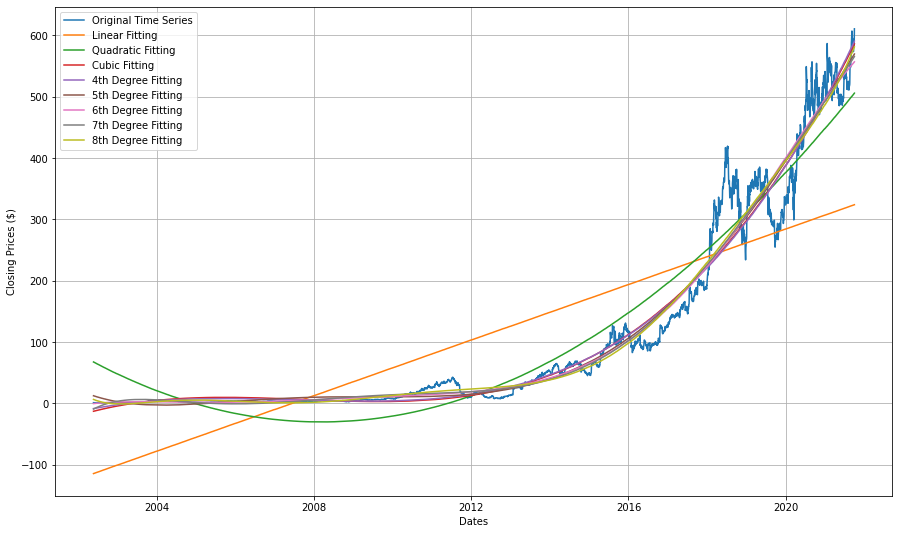

In [9]:
# Linear estimation
linTS = estimation(data.index, y, 1, 'Linear Fitting')

# Quadratic estimation
quadTS = estimation(data.index, y, 2, 'Quadratic Fitting')

# Cubic estimation
cubTS = estimation(data.index, y, 3, 'Cubic Fitting')

# 4th degree estimation
quadricTS = estimation(data.index, y, 4, '4th degree Fitting')

# 5th degree estimation
pentaTS = estimation(data.index, y, 5, '5th degree Fitting')

# 6th degree estimation
sixth_TS = estimation(data.index, y, 6, '6th degree Fitting')

# 7th degree estimation
seventh_TS = estimation(data.index, y, 7, '7th degree Fitting')

# 8th degree estimation
eighth_TS = estimation(data.index, y, 8, '8th degree Fitting')

print('MSE linear estimation:', round(mean_squared_error(y, linTS), 3))
print('MSE quadatric estimation:', round(mean_squared_error(y, quadTS), 3))
print('MSE cubic estimation:', round(mean_squared_error(y, cubTS), 3))
print('MSE 4th degree estimation:', round(mean_squared_error(y, quadricTS), 3))
print('MSE 5th degree estimation:', round(mean_squared_error(y, pentaTS), 3))
print('MSE 6th degree estimation:', round(mean_squared_error(y, sixth_TS), 3))
print('MSE 7th degree estimation:', round(mean_squared_error(y, seventh_TS), 3))
print('MSE 8th degree estimation:', round(mean_squared_error(y, eighth_TS), 3))

plot_data(
    [x for i in range(9)],
    [y, linTS, quadTS, cubTS, quadricTS, pentaTS, sixth_TS, seventh_TS, eighth_TS],
    ["Original Time Series", "Linear Fitting", "Quadratic Fitting", "Cubic Fitting", "4th Degree Fitting", "5th Degree Fitting", "6th Degree Fitting", "7th Degree Fitting", "8th Degree Fitting"]
)

# Remove trend

### Additive model

In [10]:
def remove_trend(series, estimation):
    data_no_trend = series - estimation
    return data_no_trend

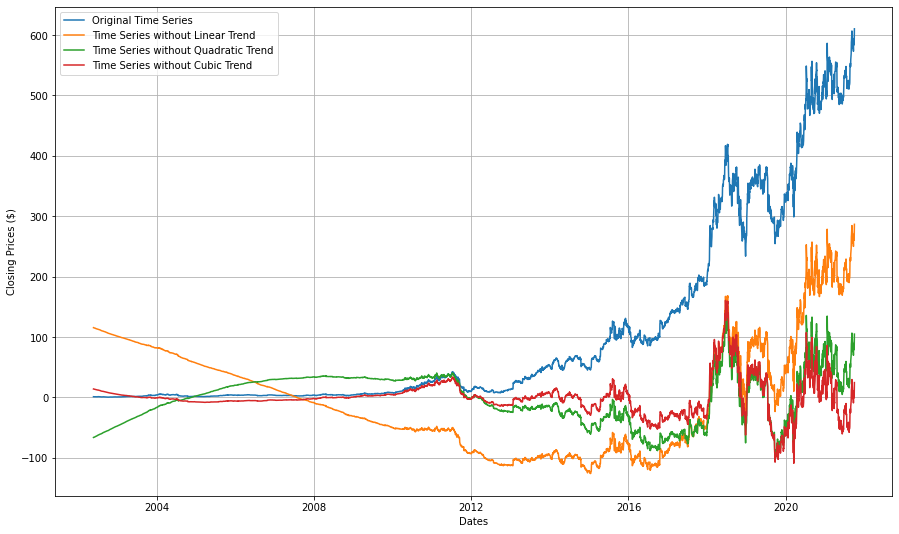

In [11]:
no_lin_trend = remove_trend(y, linTS.values)
no_quad_trend = remove_trend(y, quadTS.values)
no_cub_trend = remove_trend(y, cubTS.values)

plot_data(
    [x for i in range(4)],
    [y, no_lin_trend, no_quad_trend, no_cub_trend],
    ["Original Time Series", "Time Series without Linear Trend", "Time Series without Quadratic Trend", "Time Series without Cubic Trend"],
)

### Multiplicative model

In [12]:
def divided_trend(data, trend):
    data_no_trend = data.values/trend.values
    
    indexes = np.where((data_no_trend > (3 * np.std(data_no_trend))) | (data_no_trend < (-3 * np.std(data_no_trend))))
    if not indexes:
        data_no_trend[indexes] = np.nan
    
    return data_no_trend

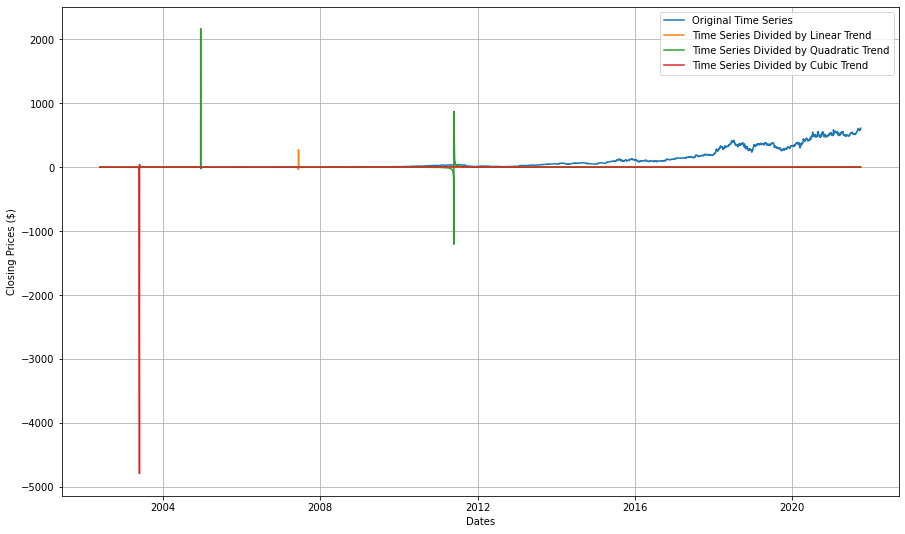

In [13]:
data_no_lin_trend = divided_trend(y, linTS)
data_no_quad_trend = divided_trend(y, quadTS)
data_no_cub_trend = divided_trend(y, cubTS)

plot_data(
    [x for i in range(4)],
    [y, data_no_lin_trend, data_no_quad_trend, data_no_cub_trend],
    ["Original Time Series", 'Time Series Divided by Linear Trend', 'Time Series Divided by Quadratic Trend', 'Time Series Divided by Cubic Trend'],
)

### Pseudo-additive (acho que é isto)

Fazer shift (por exemplo + 1000), multiplicativo e depois shift para baixo

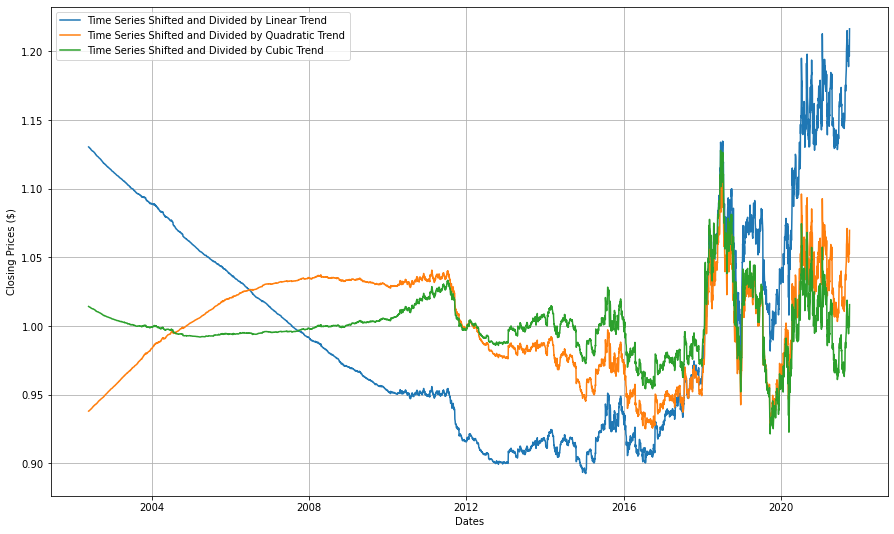

In [14]:
y_pseudo = y.copy()
y_pseudo += 1000

pseudo_data_no_lin_trend = divided_trend(y_pseudo, linTS + 1000)
pseudo_data_no_quad_trend = divided_trend(y_pseudo, quadTS + 1000)
pseudo_data_no_cub_trend = divided_trend(y_pseudo, cubTS + 1000)

'''y_pseudo -= 1000
pseudo_data_no_lin_trend -= 1000
pseudo_data_no_quad_trend -= 1000
pseudo_data_no_cub_trend -= 1000'''

plot_data(
    [x for i in range(3)],
    [pseudo_data_no_lin_trend, pseudo_data_no_quad_trend, pseudo_data_no_cub_trend],
    ['Time Series Shifted and Divided by Linear Trend', 'Time Series Shifted and Divided by Quadratic Trend', 'Time Series Shifted and Divided by Cubic Trend'],
)

# Moving average

In [15]:
def maSmooth(TSeries, omega, data_aug=False):
    M = omega.shape[0]
    lag = int(np.floor((M - 1) / 2))
    
    if data_aug: # Para corrigir início e fim por não terem M valores para calcular MA
        TSeriesAug = pd.Series(np.concatenate((np.flip(TSeries[:lag]), TSeries, np.flip(TSeries[-lag:]))))       
    else:
        TSeriesAug = TSeries
        
    nf = range(lag, TSeriesAug.size - lag)
    xf = np.zeros(TSeriesAug.size - 2 * (lag)).astype('float')
    
    sum_omega_k = 1 / float(sum(omega))
    for n in nf:
        xf[n - lag] = sum_omega_k * np.sum(np.multiply(TSeriesAug[n - lag:n + lag + 1], omega))
    xf = pd.Series(data=xf, index=TSeriesAug.index[lag:TSeriesAug.size - lag], name="Smoothed TS with M=" + str(M))
    
    return xf

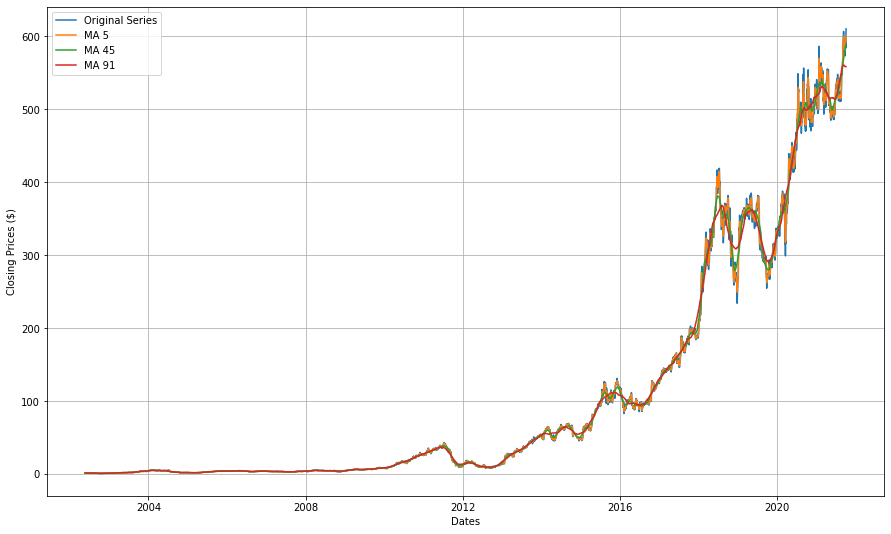

In [16]:
M = 5
omega = np.ones(M) * (1 / float(M))
smooth5 = maSmooth(y, omega, data_aug=True)

M = 45
omega = np.ones(M) * (1 / float(M))
smooth45 = maSmooth(y, omega, data_aug=True)

M = 91
omega = np.ones(M) * (1 / float(M))
smooth91 = maSmooth(y, omega, data_aug=True)

plot_data(
    [x for i in range(4)], 
    [y, smooth5, smooth45, smooth91], 
    ['Original Series', 'MA 5', 'MA 45', 'MA 91']
)

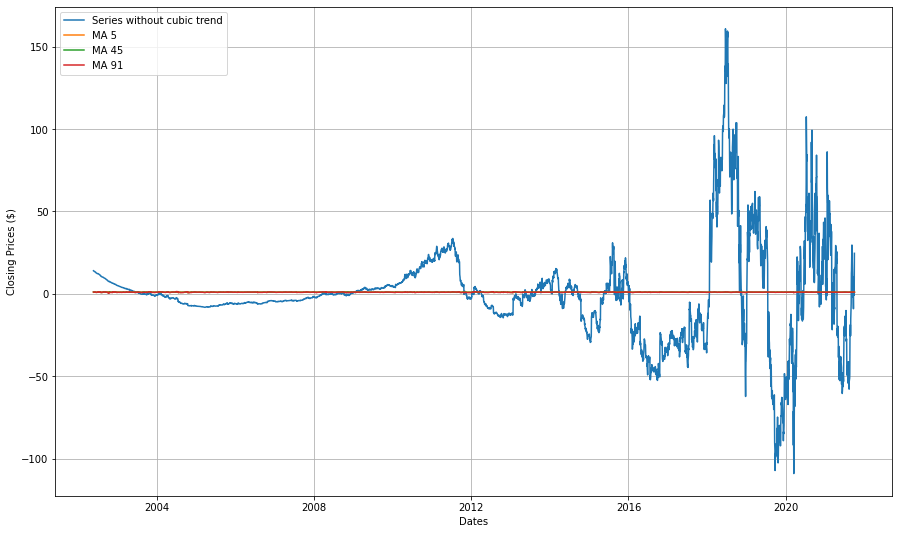

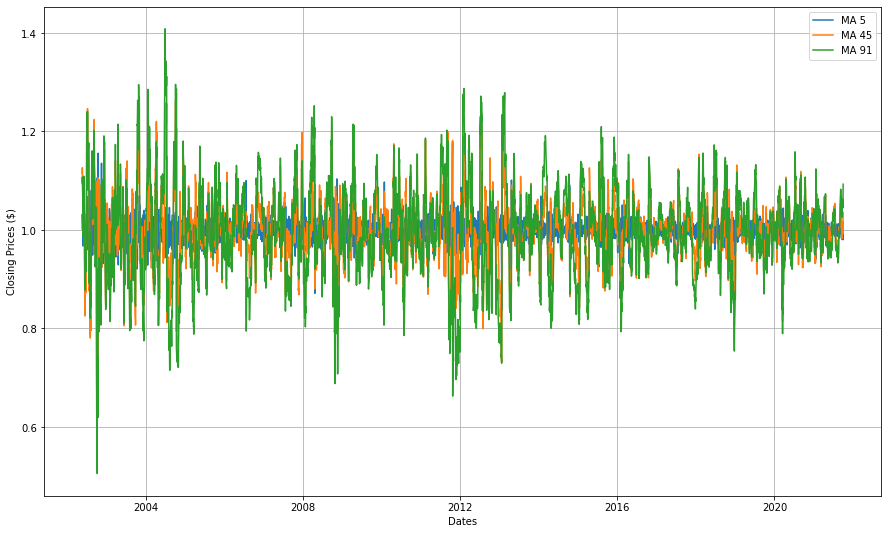

In [17]:
trend_ma5 = divided_trend(y, smooth5)
trend_ma45 = divided_trend(y, smooth45)
trend_ma91 = divided_trend(y, smooth91)

plot_data(
    [x for i in range(4)],
    [no_cub_trend, trend_ma5, trend_ma45, trend_ma91],
    ['Series without cubic trend', 'MA 5', 'MA 45', 'MA 91']
)

plot_data(
    [x for i in range(3)],
    [trend_ma5, trend_ma45, trend_ma91],
    ['MA 5', 'MA 45', 'MA 91']
)

# LOESS/LOWESS

In [18]:
def xWeights(x, xi, span):
    return (1 - abs((x - xi) / float(span)) ** 3) ** 3


def yWeights(ri, MAD):
    if np.abs(ri) < 6 * MAD:
        return (1 - ((ri / (6 * MAD)) ** 2)) ** 2
    return 0


def loessPass(TSeries, TSeriesE=pd.Series(np.array([])), span=5, timePass=True):
    lag = int((span - 1) / 2)
    xf = np.zeros(TSeries.size).astype('float')
    for k in range(TSeries.size):
        if k <= lag:  # No inicio
            win = TSeries[0:span]
            if not timePass:
                winE = TSeriesE[0:span]
            xvs = np.array(range(span))
        elif k > TSeries.size - lag:  # No fim
            win = TSeries[TSeries.size - span:TSeries.size]
            if not timePass:
                winE = TSeriesE[TSeriesE.size - span:TSeriesE.size]
            xvs = np.array(range(TSeries.size - span, TSeries.size))
        else:  # No meio
            win = TSeries[k - lag - 1:k + lag]
            if not timePass:
                winE = TSeriesE[k - lag - 1:k + lag]
            xvs = np.array(range(k - lag, k + lag + 1))

        ws = np.zeros(span).astype('float')
            
        if not timePass:
            res = np.array(win - winE)
            MAD = np.median(np.abs(res))
            
        for xw in range(len(xvs)):
            if timePass:
                ws[xw] = xWeights(k, xvs[xw], np.max((np.abs(k - xvs[0]), np.abs(k - xvs[-1]))))
            else:
                ws[xw] = yWeights(res[xw], MAD)
        exog = sm.add_constant(xvs)
        
        mod_wls = sm.WLS(win, exog, weights=ws)
        res_wls = mod_wls.fit()
        
        xf[k] = res_wls.params[1] * k + res_wls.params[0]
    return xf

def lowess(TSeries, span=5):
    xf = loessPass(TSeries, span=span, timePass=True)
    xf = loessPass(TSeries, TSeriesE=pd.Series(data=xf, index=TSeries.index), span=span, timePass=False)
    xf = pd.Series(data=xf, index=TSeries.index, name=f"Smoothed TS with M={span}")
    return xf

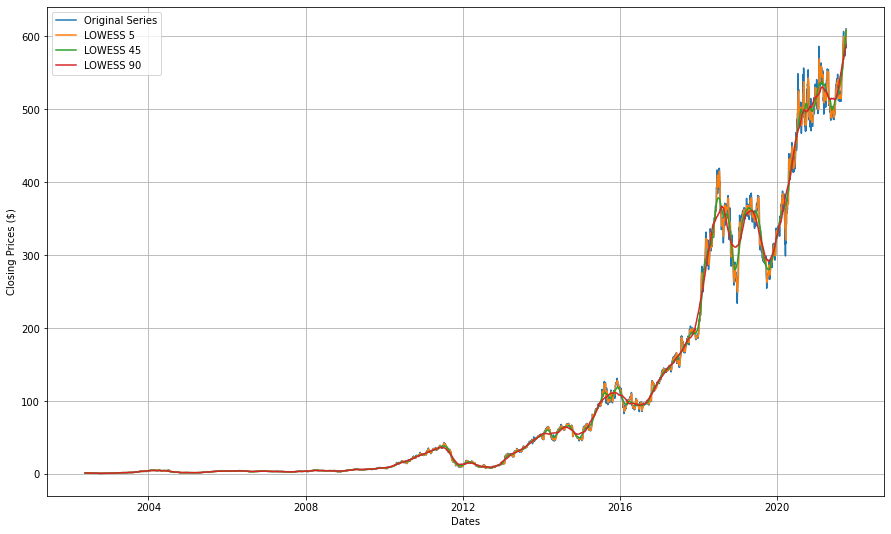

In [19]:
span = 5
lowess5 = lowess(y, span)

span = 45
lowess45 = lowess(y, span)

span = 91
lowess90 = lowess(y, span)


plot_data(
    [x for i in range(4)], 
    [y, lowess5, lowess45, lowess90],
    ['Original Series', 'LOWESS 5', 'LOWESS 45', 'LOWESS 90']
)

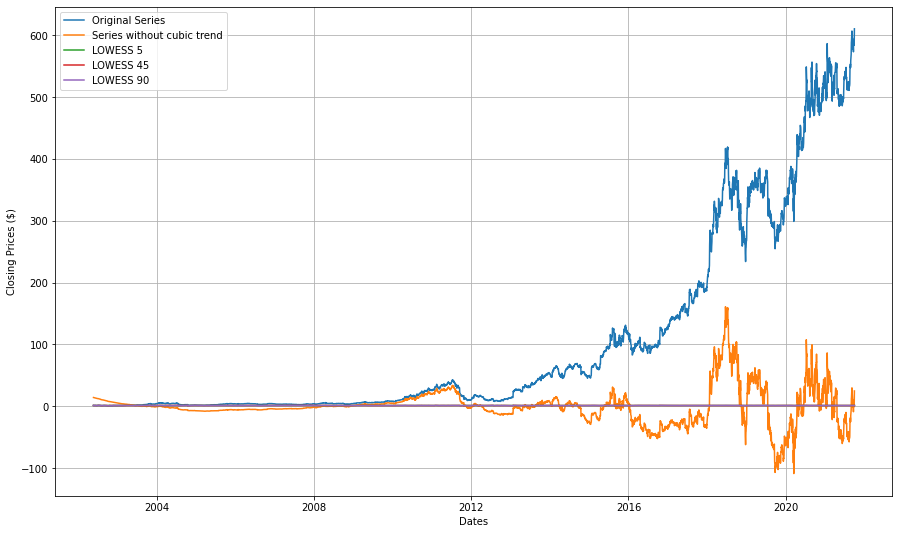

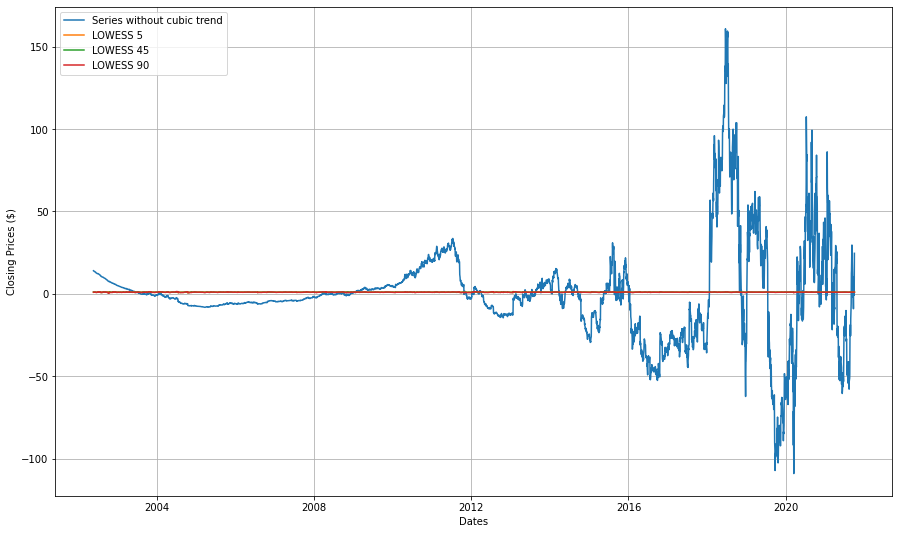

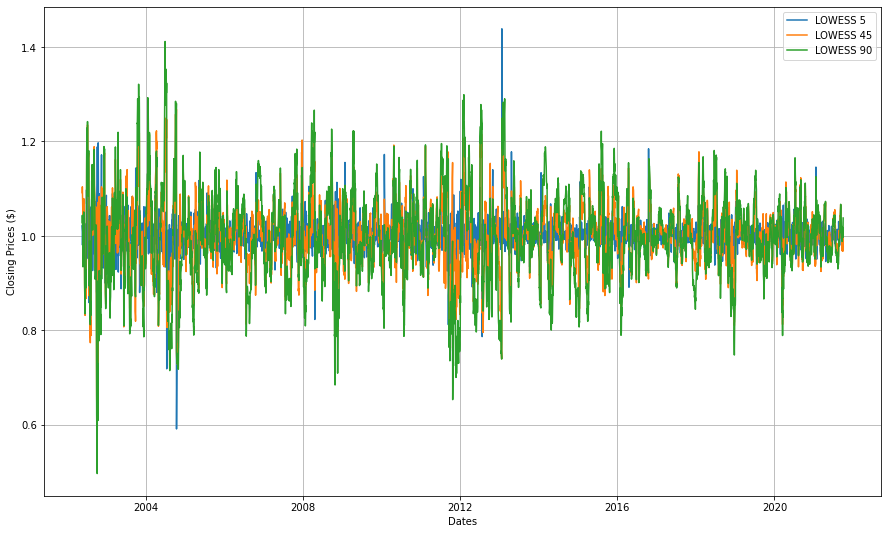

'plot_series(\n    data[\'Date\'][init:end], \n    [data["Close"][init:end], no_cub_trend, trend_lowess5, trend_lowess45, trend_lowess90], \n    \'Netflix Stock LOWESS without trend\', \n    [\'Original Series\', \'Series without cubic trend\', \'LOWESS 5\', \'LOWESS 45\', \'LOWESS 90\']\n)'

In [20]:
trend_lowess5 = divided_trend(y, lowess5)
trend_lowess45 = divided_trend(y, lowess45)
trend_lowess90 = divided_trend(y, lowess90)

plot_data(
    [x for i in range(5)], 
    [y, no_cub_trend, trend_lowess5, trend_lowess45, trend_lowess90],
    ['Original Series', 'Series without cubic trend', 'LOWESS 5', 'LOWESS 45', 'LOWESS 90']
)

plot_data(
    [x for i in range(4)], 
    [no_cub_trend, trend_lowess5, trend_lowess45, trend_lowess90],
    ['Series without cubic trend', 'LOWESS 5', 'LOWESS 45', 'LOWESS 90']
)

plot_data(
    [x for i in range(3)], 
    [trend_lowess5, trend_lowess45, trend_lowess90],
    ['LOWESS 5', 'LOWESS 45', 'LOWESS 90']
)

'''plot_series(
    data['Date'][init:end], 
    [data["Close"][init:end], no_cub_trend, trend_lowess5, trend_lowess45, trend_lowess90], 
    'Netflix Stock LOWESS without trend', 
    ['Original Series', 'Series without cubic trend', 'LOWESS 5', 'LOWESS 45', 'LOWESS 90']
)'''

# Trend with diff

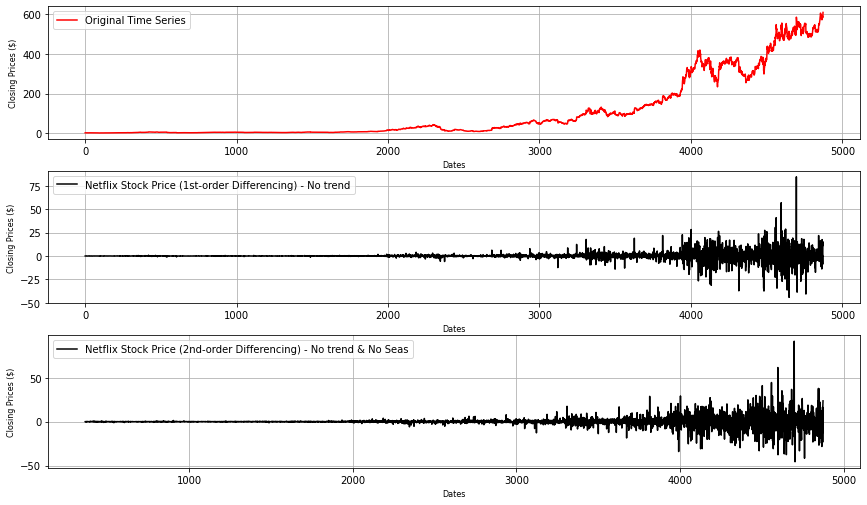

In [21]:
fig, axs = plt.subplots(3, figsize=(12, 7))
fig.tight_layout()

y.plot(ax=axs[0], label="Original Time Series", legend=True, color='r')
axs[0].set_ylabel('Closing Prices ($)', fontdict={'fontsize':8})
axs[0].set_xlabel('Dates', fontdict={'fontsize':8})

d1psT = y.diff()
d1psT.name = "Netflix Stock Price (1st-order Differencing) - No trend"
d1psT.plot(ax=axs[1], legend=True, color='k')
axs[1].set_ylabel('Closing Prices ($)', fontdict={'fontsize':8})
axs[1].set_xlabel('Dates', fontdict={'fontsize':8})

d1psTS = d1psT.diff(364)
d1psTS.name = "Netflix Stock Price (2nd-order Differencing) - No trend & No Seas"
d1psTS.plot(ax=axs[2], legend=True, color='k')
axs[2].set_ylabel('Closing Prices ($)', fontdict={'fontsize':8})
axs[2].set_xlabel('Dates', fontdict={'fontsize':8})

plt.show()

# Separate trend and seasonality

<Figure size 1080x648 with 0 Axes>

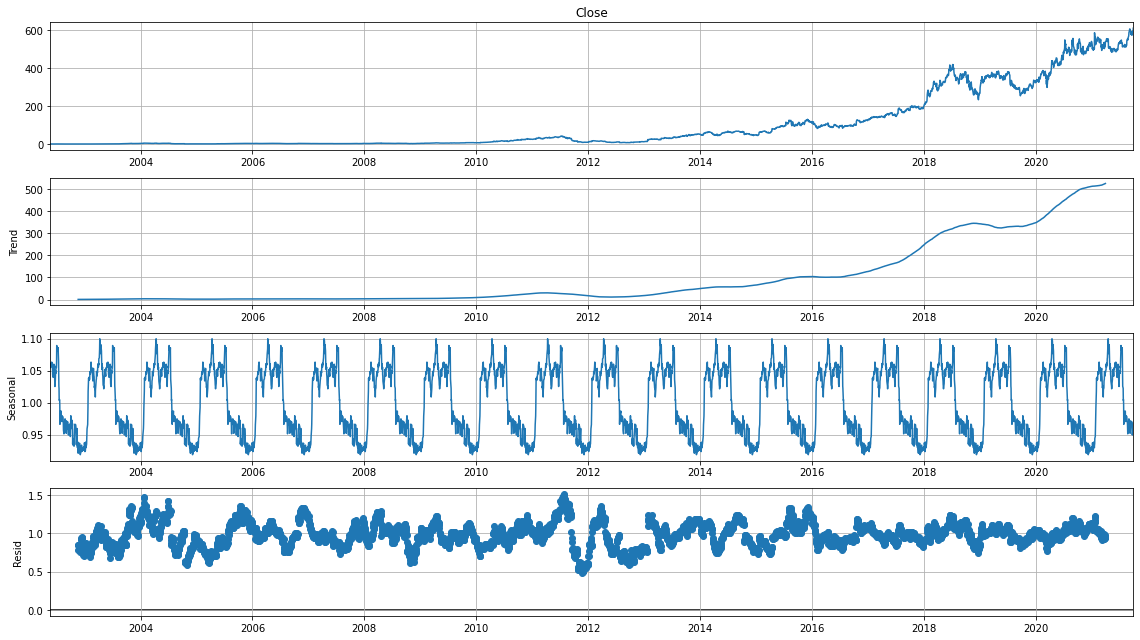

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

values = y
values.index = x

result = seasonal_decompose(values, model='multiplicative', period=252)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

# ADF test (Dicky Fuller)

In [23]:
from statsmodels.tsa.stattools import adfuller

def test_stationary(time_series, alpha=0.05):
    res = adfuller(time_series.dropna())
    
    print('ADF Statistic: %f' % res[0])
    print('p-value: %f' % res[1])
    print('Critical Values:')
    
    for key, value in res[4].items():
        print('\t%s: %.3f' % (key, value))
    print("> This Time Series is Not Stationary (AR(1))") if res[1] > alpha else print("> This Time Series is Stationary")

def rolling_mean_std(timeseries, lag):
    rolmean = timeseries.rolling(lag).mean()
    rolstd = timeseries.rolling(lag).std()
    
    #Plot rolling statistics:
    plt.figure()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

1. Verify if the original TS is stationary. If so, we are done with d=0 and D=0


2. If the series is not stationary and has a trend apply a simple differencing operation to remove the trend. If trend is removed then d=1, if not apply d=2 (Should be enough!!)


----- #1 -----
ADF Statistic: 2.793546
p-value: 1.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
> This Time Series is Not Stationary (AR(1))
----- #2 -----
ADF Statistic: -12.296602
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
> This Time Series is Stationary
----- #3 -----
ADF Statistic: -11.273039
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
> This Time Series is Stationary


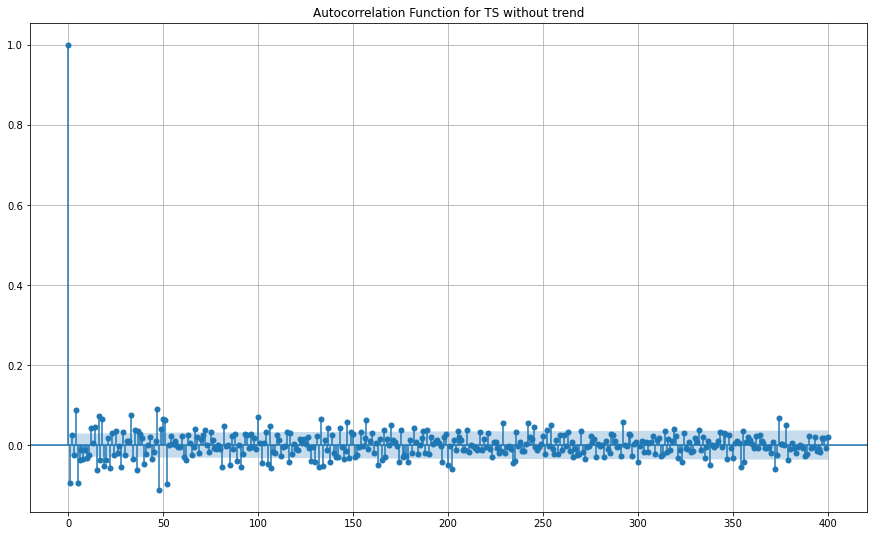

In [24]:
# %matplotlib qt

# 1
print("----- #1 -----")
test_stationary(y)

# 2
print("----- #2 -----")
no_trend = y.diff()
plot_acf(no_trend.dropna(), lags=400, title='Autocorrelation Function for TS without trend')
test_stationary(no_trend.dropna())

# 3
print("----- #3 -----")
no_trend_season = no_trend.diff(364)
test_stationary(no_trend_season.dropna())
# plot_acf(y, lags=365, title="Autocorrelation Function (lags=365)")
# plot_pacf(y, lags=365, title="Partial Autocorrelation Function (lags=365)")

ADF Statistic: 2.793546
p-value: 1.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
> This Time Series is Not Stationary (AR(1))
-----------------------------
ADF Statistic: -12.296602
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
> This Time Series is Stationary
---------------------------------------------------------------------------------------


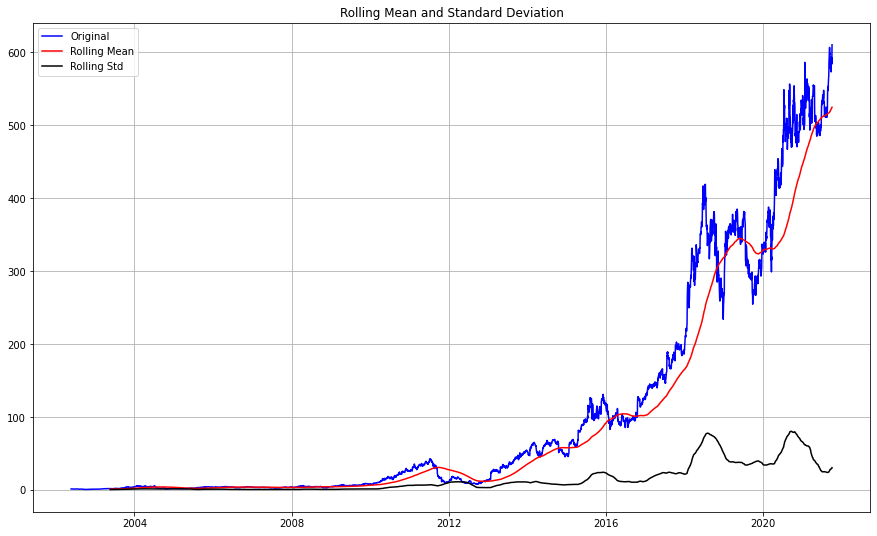

------------------------------------------------------------------------------


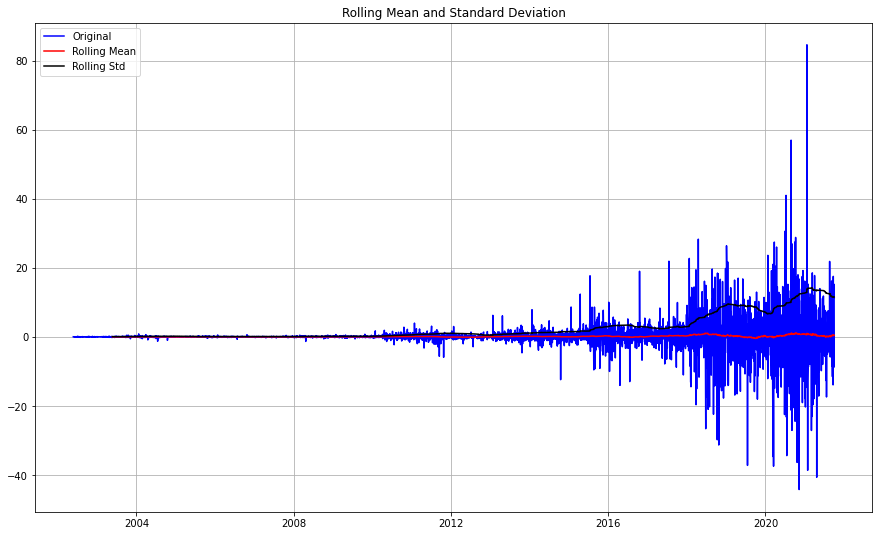

In [25]:
# If the p-value is greater than alpha, you assume that the null hypothesis is true.


# If P-Value < Alpha : This means that the NULL hypothesis can be rejected => (aka it is Stationary)
# If P-Value > Alpha : This means that the NULL hypothesis is accepted (aka failed to be rejected) => (AR(1) and NOT Stationary).

test_stationary(y)
print("-----------------------------")
test_stationary(y.diff())
print("---------------------------------------------------------------------------------------")
rolling_mean_std(y, 252)
print("------------------------------------------------------------------------------")
rolling_mean_std(y.diff(), 252)

## ARIMA testing

In [26]:
%%time

errors_aic_without_season = None
errors_bic_without_season = None
errors_mse_without_season = None

if os.path.isfile("best_params_aic_without_season.csv") and os.path.isfile("best_params_bic_without_season.csv") and os.path.isfile("best_params_mse_without_season.csv"):
    errors_aic_without_season = pd.read_csv("best_params_aic_without_season.csv")
    errors_bic_without_season = pd.read_csv("best_params_bic_without_season.csv")
    errors_mse_without_season = pd.read_csv("best_params_mse_without_season.csv")
else:
    errors_aic_without_season = pd.DataFrame(columns=["p", "d", "q", "value"])
    errors_bic_without_season = pd.DataFrame(columns=["p", "d", "q", "value"])
    errors_mse_without_season = pd.DataFrame(columns=["p", "d", "q", "value"])
    for p in range(10):
        for q in range(10):
            model = ARIMA(y_train, order=(p, 1, q))
            fitted = model.fit()

            errors_aic_without_season = errors_aic_without_season.append({"p": p, "d": 1, "q": q, "value": fitted.aic}, ignore_index=True)
            errors_bic_without_season = errors_bic_without_season.append({"p": p, "d": 1, "q": q, "value": fitted.bic}, ignore_index=True)
            errors_mse_without_season = errors_mse_without_season.append({"p": p, "d": 1, "q": q, "value": fitted.mse}, ignore_index=True)

            print(f'p={p}, d=1, q={q} / AIC: {fitted.aic}')
            print(f'p={p}, d=1, q={q} / BIC: {fitted.bic}')
            print(f'p={p}, d=1, q={q} / MSE: {fitted.mse}')
            print("--------------------------------------------")
    errors_aic_without_season.to_csv("best_params_aic_without_season.csv", index=False)
    errors_bic_without_season.to_csv("best_params_bic_without_season.csv", index=False)
    errors_mse_without_season.to_csv("best_params_mse_without_season.csv", index=False)

Wall time: 15 ms


### Best parameters AIC
- Train: ARIMA(8, 1, 9) / AIC: 24724.40679352591
- Test: MSE - 1707.9537726277492

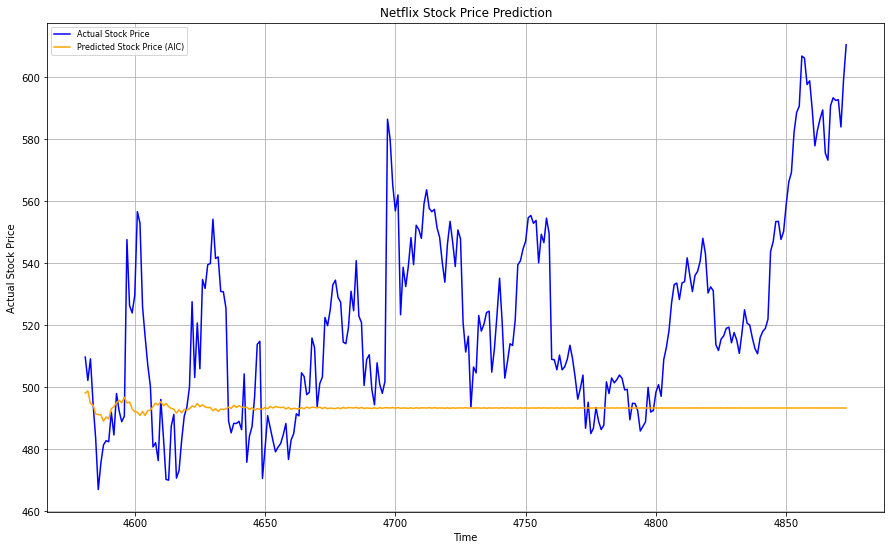

Best parameters AIC: (8.0, 1.0, 9.0)
AIC: 24724.40679352591
----------------
MSE(y_test, pred): 1707.9537726277492


In [27]:
mini_aic = np.min(errors_aic_without_season["value"])
row_aic = errors_aic_without_season[errors_aic_without_season["value"] == mini_aic]
p_aic, d_aic, q_aic = row_aic["p"].values[0], row_aic["d"].values[0], row_aic["q"].values[0]

# d = 2, sem seasonal_order
# mesmo nao havendo repetitividade, o facto de termos em conta valores mais atras melhora
# exponential smoothing
model = ARIMA(y_train, order=(p_aic, d_aic, q_aic))
fitted = model.fit()
fc = fitted.forecast(steps=len(y_test), alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc)
fc_series.index = X_test.index

plt.figure()
plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price (AIC)')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

print(f'Best parameters AIC: ({p_aic}, {d_aic}, {q_aic})\nAIC: {mini_aic}')
print(f"----------------\nMSE(y_test, pred): {mean_squared_error(y_test, fc)}")

### Best parameters BIC
- Train: ARIMA(6, 1, 6) / BIC: 24814.314967361675
- Test: MSE - 1629.6696215579482

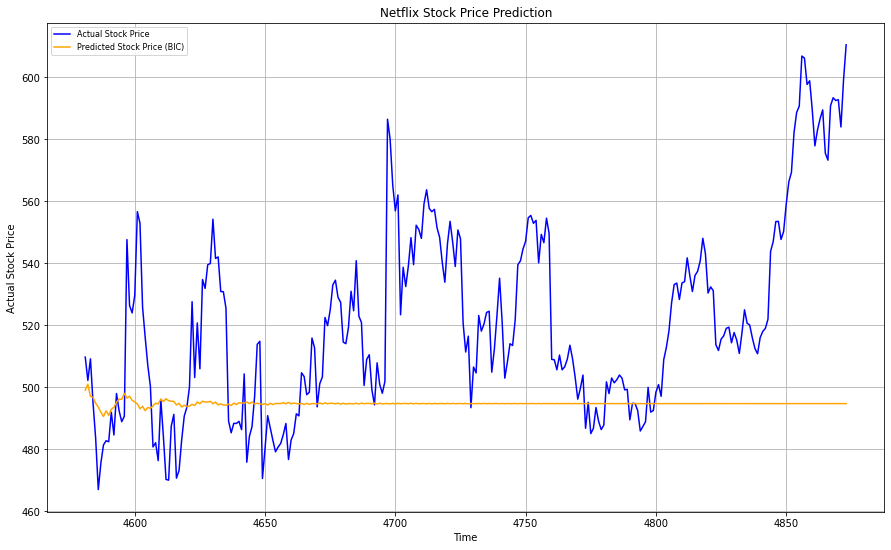

Best parameters BIC: (6.0, 1.0, 6.0)
BIC: 24814.314967361675
----------------
MSE(y_test, pred): 1629.6696215579482


In [28]:
mini_bic = np.min(errors_bic_without_season["value"])
row_bic = errors_bic_without_season[errors_bic_without_season["value"] == mini_bic]
p_bic, d_bic, q_bic = row_bic["p"].values[0], row_bic["d"].values[0], row_bic["q"].values[0]

# d = 2, sem seasonal_order
# mesmo nao havendo repetitividade, o facto de termos em conta valores mais atras melhora
# exponential smoothing
model = ARIMA(y_train, order=(p_bic, d_bic, q_bic))
fitted = model.fit()
fc = fitted.forecast(steps=len(y_test), alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc)
fc_series.index = X_test.index

plt.figure()
plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price (BIC)')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

print(f'Best parameters BIC: ({p_bic}, {d_bic}, {q_bic})\nBIC: {mini_bic}')
print(f"----------------\nMSE(y_test, pred): {mean_squared_error(y_test, fc)}")

### Best parameters MSE
- Train: ARIMA(9, 1, 9) / MSE: 12.833600384742327
- Test: MSE - 1618.1646610028688

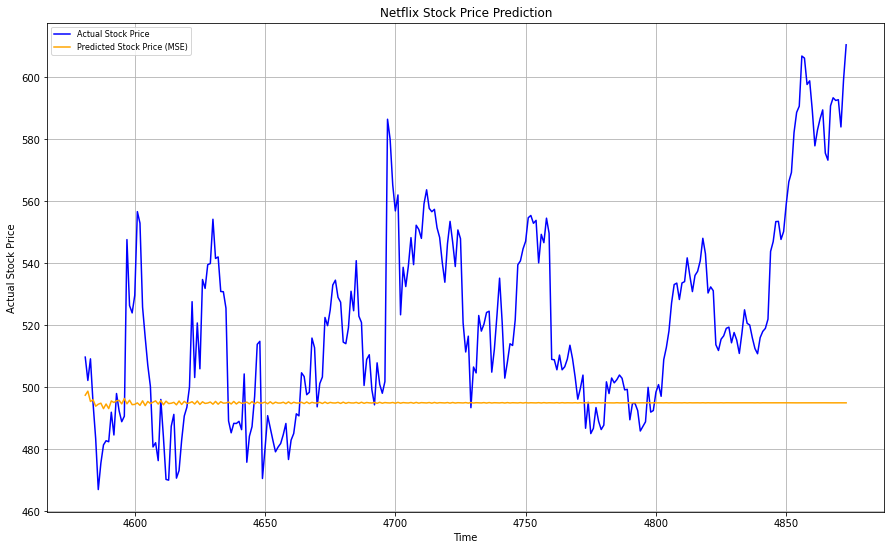

Best parameters MSE: (9.0, 1.0, 9.0)
MSE: 12.833600384742327
----------------
MSE(y_test, pred): 1618.1646610028688


In [29]:
mini_mse = np.min(errors_mse_without_season["value"])
row_mse = errors_mse_without_season[errors_mse_without_season["value"] == mini_mse]
p_mse, d_mse, q_mse = row_mse["p"].values[0], row_mse["d"].values[0], row_mse["q"].values[0]

# d = 2, sem seasonal_order
# mesmo nao havendo repetitividade, o facto de termos em conta valores mais atras melhora
# exponential smoothing
model = ARIMA(y_train, order=(p_mse, d_mse, q_mse))
fitted = model.fit()
fc = fitted.forecast(steps=len(y_test), alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc)
fc_series.index = X_test.index

plt.figure()
# plt.plot(y_train, label='training')
plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price (MSE)')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

print(f'Best parameters MSE: ({p_mse}, {d_mse}, {q_mse})\nMSE: {mini_mse}')
print(f"----------------\nMSE(y_test, pred): {mean_squared_error(y_test, fc)}")

## ARIMA testing with semi-fixed window (start fixed, end variable)

Test MSE: 1640.943831989846


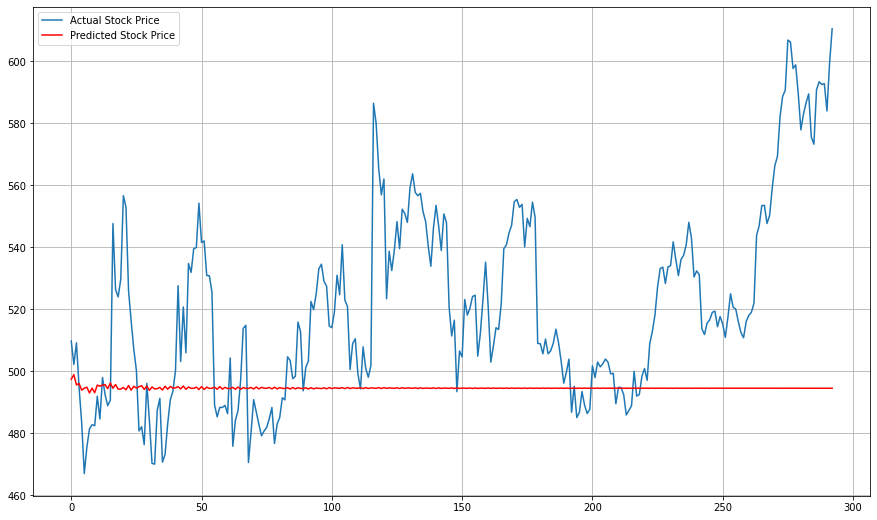

Wall time: 304 ms


In [30]:
%%time

predictions = y_train.tolist()
y_test_copy = y_test.tolist()

if os.path.isfile("arima_semi-fixed.txt"):
    with open("arima_semi-fixed.txt", "r") as f:
        aux = f.read()
        meh = aux.split(",")
        for i in range(len(meh)):
            predictions.append(float(meh[i]))
else:
    for t in range(len(y_test_copy)):
        model = ARIMA(predictions, order=(9, 1, 9))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = y_test_copy[t]
        print(f'[{t + 1}] predicted={yhat}, expected={obs}')

    with open("arima_semi-fixed.txt", "w") as f:
        for i in predictions[len(y_train):]:
            f.write(str(i) + ',')
    
# evaluate forecasts
mse = mean_squared_error(y_test_copy, predictions[len(y_train):])
print(f'Test MSE: {mse}')

# plot forecasts against actual outcomes
plt.figure()
plt.plot(y_test_copy, label="Actual Stock Price")
plt.plot(predictions[len(y_train):], color='red', label="Predicted Stock Price")
plt.legend()
plt.show()

## ARIMA testing with variable window (1, 5, 22, 88, 252)

Test MSE (len(y_test_copy) = 293 / len(forecasts) = 293): 145.44885626891693


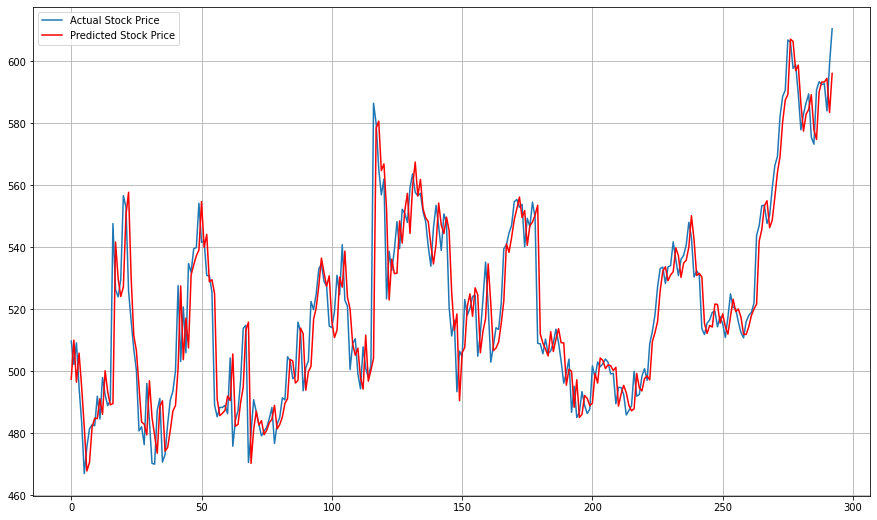

Wall time: 440 ms


In [31]:
%%time

predictions = y_train.tolist()
y_test_copy = y_test.tolist()

window_size = 1
forecasts = []

if os.path.isfile(f"arima_variable-{window_size}.txt"):
    with open(f"arima_variable-{window_size}.txt", "r") as f:
        aux = f.read()
        meh = aux.split(",")
        for i in range(len(meh)):
            forecasts.append(float(meh[i]))
else:
    for t in range(0, len(y_test_copy), window_size):
        '''print(f"{t}:{len(y_train) + t}")
        print(f"len janela: {t}:{t+window_size-1}")'''
        model = ARIMA(predictions[t:len(y_train) + t], order=(9, 1, 9))
        model_fit = model.fit()
        output = model_fit.forecast(steps=window_size)
        yhat = output
        # print(f"Forecasted values: {yhat}")
        forecasts.append(yhat)
        obs = y_test_copy[t:t+window_size]
        predictions += obs
        # print(f"Predictions: [{predictions[-5-window_size]}, {predictions[-4-window_size]}, {predictions[-3-window_size]}, {predictions[-2-window_size]}, {predictions[-1-window_size]}], obs: {y_test_copy[t:t+window_size]}")
        print(f'[{t + 1}] predicted={yhat}, expected={obs}')
        print("-------------")

    with open(f"arima_variable-{window_size}.txt", "w") as f:
        for i in forecasts:
            f.write(str(i) + ',')

plt.figure()
if len(y_test_copy) < len(forecasts):
    mse = mean_squared_error(y_test_copy, forecasts[:len(y_test_copy)])
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts[:len(y_test_copy)], color='red', label="Predicted Stock Price")
elif len(y_test_copy) > len(forecasts):
    mse = mean_squared_error(y_test_copy[:len(forecasts)], forecasts)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts)}): {mse}')
    plt.plot(y_test_copy[:len(forecasts)], label="Actual Stock Price")
    plt.plot(forecasts, color='red', label="Predicted Stock Price")
else:
    mse = mean_squared_error(y_test_copy, forecasts)#[:len(y_test_copy)])
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts, color='red', label="Predicted Stock Price")
plt.legend()
plt.show()

Test MSE (len(y_test_copy) = 293 / len(forecasts) = 295): 358.87079076969513


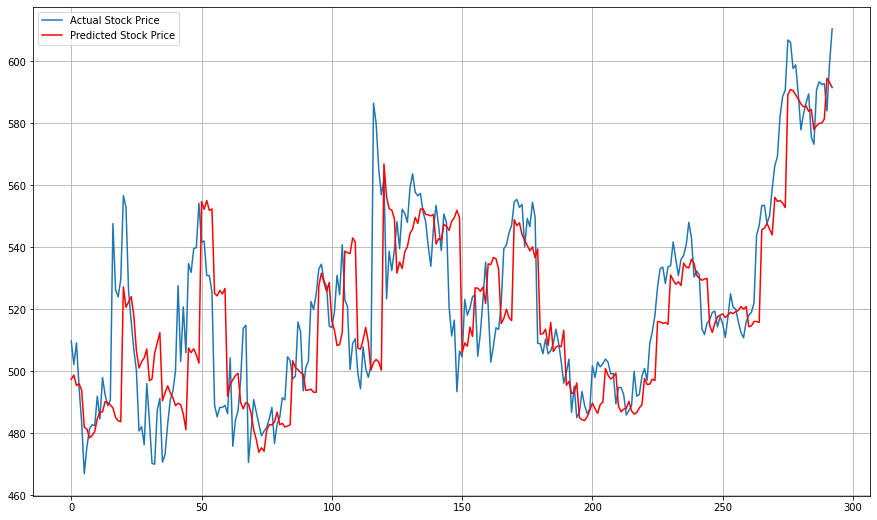

Wall time: 512 ms


In [32]:
%%time

predictions = y_train.tolist()
y_test_copy = y_test.tolist()

window_size = 5
forecasts = []

if os.path.isfile(f"arima_variable-{window_size}.txt"):
    with open(f"arima_variable-{window_size}.txt", "r") as f:
        aux = f.read()
        meh = aux.split(",")
        for i in range(len(meh)):
            forecasts.append(float(meh[i]))
else:
    for t in range(0, len(y_test_copy), window_size):
        '''print(f"{t}:{len(y_train) + t}")
        print(f"len janela: {t}:{t+window_size-1}")'''
        model = ARIMA(predictions[t:len(y_train) + t], order=(9, 1, 9))
        model_fit = model.fit()
        output = model_fit.forecast(steps=window_size)
        yhat = output
        # print(f"Forecasted values: {yhat}")
        forecasts.append(yhat)
        obs = y_test_copy[t:t+window_size]
        predictions += obs
        # print(f"Predictions: [{predictions[-5-window_size]}, {predictions[-4-window_size]}, {predictions[-3-window_size]}, {predictions[-2-window_size]}, {predictions[-1-window_size]}], obs: {y_test_copy[t:t+window_size]}")
        print(f'[{t + 1}] predicted={yhat}, expected={obs}')
        print("-------------")

    with open(f"arima_variable-{window_size}.txt", "w") as f:
        for i in forecasts:
            f.write(str(i) + ',')

plt.figure()
if len(y_test_copy) < len(forecasts):
    mse = mean_squared_error(y_test_copy, forecasts[:len(y_test_copy)])
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts[:len(y_test_copy)], color='red', label="Predicted Stock Price")
elif len(y_test_copy) > len(forecasts):
    mse = mean_squared_error(y_test_copy[:len(forecasts)], forecasts)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts)}): {mse}')
    plt.plot(y_test_copy[:len(forecasts)], label="Actual Stock Price")
    plt.plot(forecasts, color='red', label="Predicted Stock Price")
else:
    mse = mean_squared_error(y_test_copy, forecasts)#[:len(y_test_copy)])
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts, color='red', label="Predicted Stock Price")
plt.legend()
plt.show()

Test MSE (len(y_test_copy) = 293 / len(forecasts) = 308): 1114.1578717641519


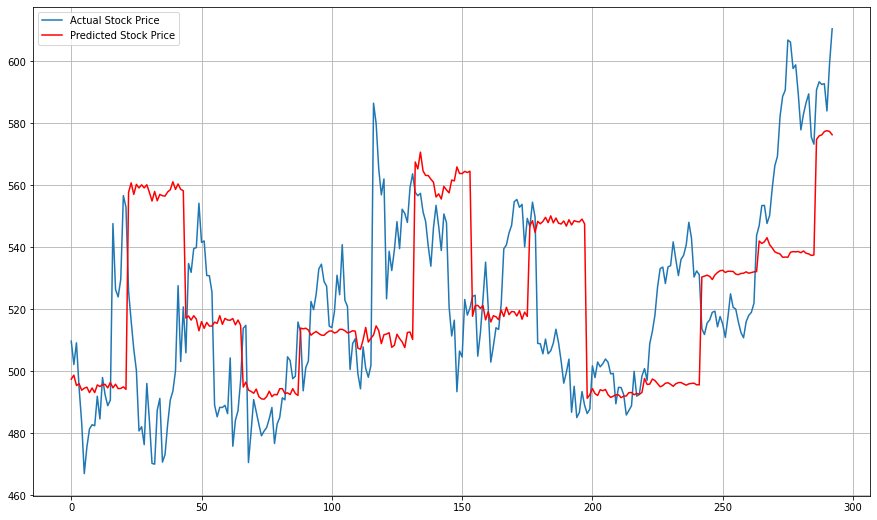

Wall time: 265 ms


In [50]:
%%time

predictions = y_train.tolist()
y_test_copy = y_test.tolist()

window_size = 22
forecasts = []

if os.path.isfile(f"arima_variable-{window_size}.txt"):
    with open(f"arima_variable-{window_size}.txt", "r") as f:
        aux = f.read()
        meh = aux.split(",")
        for i in range(len(meh)):
            forecasts.append(float(meh[i]))
else:
    for t in range(0, len(y_test_copy), window_size):
        '''print(f"{t}:{len(y_train) + t}")
        print(f"len janela: {t}:{t+window_size-1}")'''
        model = ARIMA(predictions[t:len(y_train) + t], order=(9, 1, 9))
        model_fit = model.fit()
        output = model_fit.forecast(steps=window_size)
        yhat = output
        # print(f"Forecasted values: {yhat}")
        forecasts.append(yhat)
        obs = y_test_copy[t:t+window_size]
        predictions += obs
        # print(f"Predictions: [{predictions[-5-window_size]}, {predictions[-4-window_size]}, {predictions[-3-window_size]}, {predictions[-2-window_size]}, {predictions[-1-window_size]}], obs: {y_test_copy[t:t+window_size]}")
        print(f'[{t + 1}] predicted={yhat}, expected={obs}')
        print("-------------")

    with open(f"arima_variable-{window_size}.txt", "w") as f:
        for i in forecasts:
            f.write(str(i) + ',')

plt.figure()
if len(y_test_copy) < len(forecasts):
    mse = mean_squared_error(y_test_copy, forecasts[:len(y_test_copy)])
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts[:len(y_test_copy)], color='red', label="Predicted Stock Price")
elif len(y_test_copy) > len(forecasts):
    mse = mean_squared_error(y_test_copy[:len(forecasts)], forecasts)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts)}): {mse}')
    plt.plot(y_test_copy[:len(forecasts)], label="Actual Stock Price")
    plt.plot(forecasts, color='red', label="Predicted Stock Price")
else:
    mse = mean_squared_error(y_test_copy, forecasts)#[:len(y_test_copy)])
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts, color='red', label="Predicted Stock Price")
plt.legend()
plt.show()

Test MSE (len(y_test_copy) = 293 / len(forecasts) = 352): 1072.9054976812085


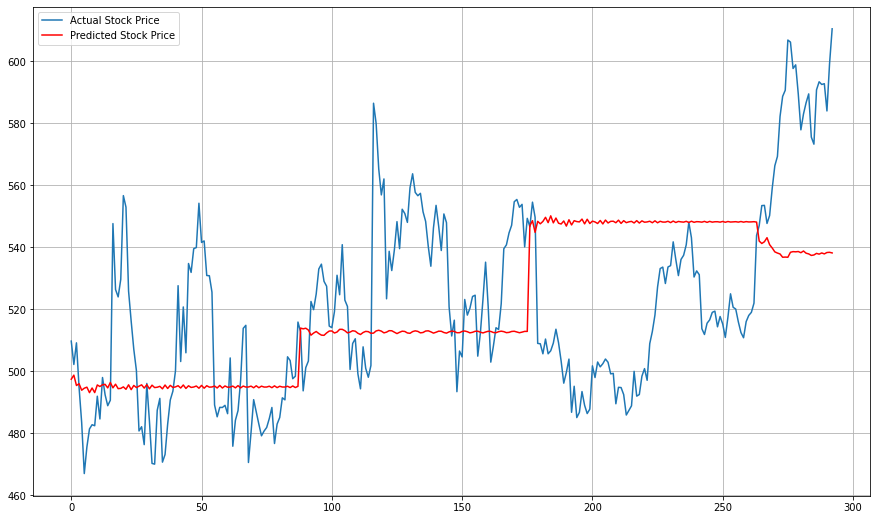

Wall time: 377 ms


In [48]:
%%time

predictions = y_train.tolist()
y_test_copy = y_test.tolist()

window_size = 88
forecasts = []

if os.path.isfile(f"arima_variable-{window_size}.txt"):
    with open(f"arima_variable-{window_size}.txt", "r") as f:
        aux = f.read()
        meh = aux.split(",")
        for i in range(len(meh)):
            forecasts.append(float(meh[i]))
else:
    for t in range(0, len(y_test_copy), window_size):
        '''print(f"{t}:{len(y_train) + t}")
        print(f"len janela: {t}:{t+window_size-1}")'''
        model = ARIMA(predictions[t:len(y_train) + t], order=(9, 1, 9))
        model_fit = model.fit()
        output = model_fit.forecast(steps=window_size)
        yhat = output
        # print(f"Forecasted values: {yhat}")
        forecasts.append(yhat)
        obs = y_test_copy[t:t+window_size]
        predictions += obs
        # print(f"Predictions: [{predictions[-5-window_size]}, {predictions[-4-window_size]}, {predictions[-3-window_size]}, {predictions[-2-window_size]}, {predictions[-1-window_size]}], obs: {y_test_copy[t:t+window_size]}")
        print(f'[{t + 1}] predicted={yhat}, expected={obs}')
        print("-------------")

    with open(f"arima_variable-{window_size}.txt", "w") as f:
        for i in forecasts:
            f.write(str(i) + ',')

plt.figure()
if len(y_test_copy) < len(forecasts):
    mse = mean_squared_error(y_test_copy, forecasts[:len(y_test_copy)])
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts[:len(y_test_copy)], color='red', label="Predicted Stock Price")
elif len(y_test_copy) > len(forecasts):
    mse = mean_squared_error(y_test_copy[:len(forecasts)], forecasts)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts)}): {mse}')
    plt.plot(y_test_copy[:len(forecasts)], label="Actual Stock Price")
    plt.plot(forecasts, color='red', label="Predicted Stock Price")
else:
    mse = mean_squared_error(y_test_copy, forecasts)#[:len(y_test_copy)])
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts, color='red', label="Predicted Stock Price")
plt.legend()
plt.show()

Test MSE (len(y_test_copy) = 293 / len(forecasts) = 504): 1326.0626471257433


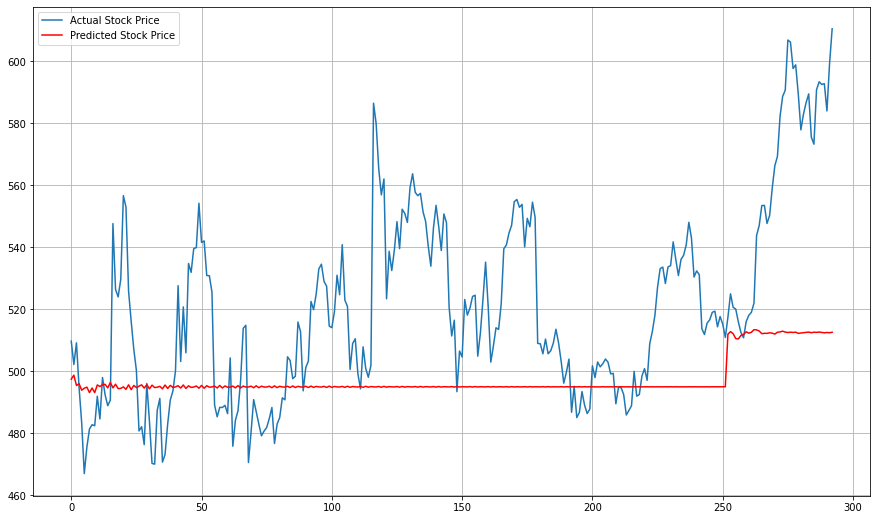

Wall time: 410 ms


In [49]:
%%time

predictions = y_train.tolist()
y_test_copy = y_test.tolist()

window_size = 252
forecasts = []

if os.path.isfile(f"arima_variable-{window_size}.txt"):
    with open(f"arima_variable-{window_size}.txt", "r") as f:
        aux = f.read()
        meh = aux.split(",")
        for i in range(len(meh)):
            forecasts.append(float(meh[i]))
else:
    for t in range(0, len(y_test_copy), window_size):
        '''print(f"{t}:{len(y_train) + t}")
        print(f"len janela: {t}:{t+window_size-1}")'''
        model = ARIMA(predictions[t:len(y_train) + t], order=(9, 1, 9))
        model_fit = model.fit()
        output = model_fit.forecast(steps=window_size)
        yhat = output
        # print(f"Forecasted values: {yhat}")
        forecasts.append(yhat)
        obs = y_test_copy[t:t+window_size]
        predictions += obs
        # print(f"Predictions: [{predictions[-5-window_size]}, {predictions[-4-window_size]}, {predictions[-3-window_size]}, {predictions[-2-window_size]}, {predictions[-1-window_size]}], obs: {y_test_copy[t:t+window_size]}")
        print(f'[{t + 1}] predicted={yhat}, expected={obs}')
        print("-------------")

    with open(f"arima_variable-{window_size}.txt", "w") as f:
        for i in forecasts:
            f.write(str(i) + ',')

plt.figure()
if len(y_test_copy) < len(forecasts):
    mse = mean_squared_error(y_test_copy, forecasts[:len(y_test_copy)])
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts[:len(y_test_copy)], color='red', label="Predicted Stock Price")
elif len(y_test_copy) > len(forecasts):
    mse = mean_squared_error(y_test_copy[:len(forecasts)], forecasts)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts)}): {mse}')
    plt.plot(y_test_copy[:len(forecasts)], label="Actual Stock Price")
    plt.plot(forecasts, color='red', label="Predicted Stock Price")
else:
    mse = mean_squared_error(y_test_copy, forecasts)#[:len(y_test_copy)])
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts, color='red', label="Predicted Stock Price")
plt.legend()
plt.show()

## Holt's ES (Double Exponential Smoothing)

In [36]:
%%time

des_aic = None
des_bic = None
des_sse = None

if os.path.isfile("des_aic.csv") and os.path.isfile("des_bic.csv") and os.path.isfile("des_sse.csv"):
    des_aic = pd.read_csv("des_aic.csv")
    des_bic = pd.read_csv("des_bic.csv")
    des_sse = pd.read_csv("des_sse.csv")
else:
    des_aic = pd.DataFrame(columns=["method", "alpha", "beta", "value"])
    des_bic = pd.DataFrame(columns=["method", "alpha", "beta", "value"])
    des_sse = pd.DataFrame(columns=["method", "alpha", "beta", "value"])
    
    im = ['estimated', 'heuristic', 'legacy-heuristic']
    alphas = np.arange(0.1, 1, 0.01)
    betas = np.arange(0.1, 1, 0.01)
    
    for i in im:
        for a in alphas:
            for b in betas:
                model = Holt(y_train, initialization_method=i)
                fitted = model.fit(smoothing_level=a, smoothing_trend=b)
                
                # fcast = fitted.forecast(len(y_test))
        
                '''plt.figure()
                plt.plot(y_test, c='blue', label='True values')
                plt.plot(fcast, c='red', label='Prediction')
                plt.show()'''

                des_aic = des_aic.append({"method": i, "alpha": a, "beta": b, "value": fitted.aic}, ignore_index=True)
                des_bic = des_bic.append({"method": i, "alpha": a, "beta": b, "value": fitted.bic}, ignore_index=True)
                des_sse = des_sse.append({"method": i, "alpha": a, "beta": b, "value": fitted.sse}, ignore_index=True)
                
                print(f'method={i}, alpha={a}, beta={b} / AIC: {fitted.aic}')
                print(f'method={i}, alpha={a}, beta={b} / BIC: {fitted.bic}')
                print(f'method={i}, alpha={a}, beta={b} / SSE: {fitted.sse}')
                print("--------------------------------------------")
    des_aic.to_csv("des_aic.csv", index=False)
    des_bic.to_csv("des_bic.csv", index=False)
    des_sse.to_csv("des_sse.csv", index=False)
            

Wall time: 119 ms


Best parameters AIC: (estimated, 0.8899999999999996, 0.1)
AIC: 12162.62131610385


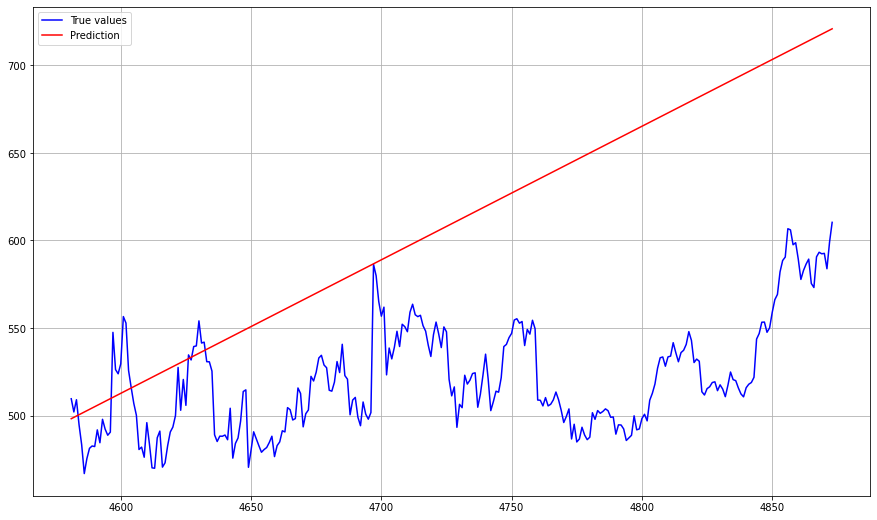

----------------
MSE(y_test, pred): 11009.153165654892


In [37]:
mini_aic = np.min(des_aic["value"])
row_aic = des_aic[des_aic["value"] == mini_aic]
method_aic, alpha_aic, beta_aic = row_aic["method"].values[0], row_aic["alpha"].values[0], row_aic["beta"].values[0]

print(f'Best parameters AIC: ({method_aic}, {alpha_aic}, {beta_aic})\nAIC: {mini_aic}')

model = Holt(y_train, initialization_method=method_aic)
fitted = model.fit(smoothing_level=alpha_aic, smoothing_trend=beta_aic)  # 0.2 / 0.42

fcast = fitted.forecast(len(y_test))

plt.figure()
plt.plot(y_test, c='blue', label='True values')
plt.plot(fcast, c='red', label='Prediction')
plt.legend()
plt.show()

print(f"----------------\nMSE(y_test, pred): {mean_squared_error(y_test, fcast)}")

Best parameters BIC: (estimated, 0.8899999999999996, 0.1)
BIC: 12188.340006479397


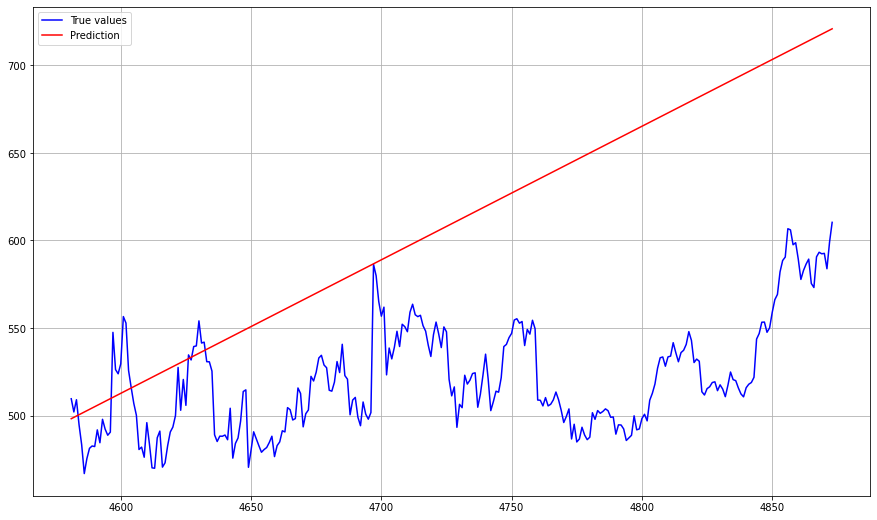

----------------
MSE(y_test, pred): 11009.153165654892


In [38]:
mini_bic = np.min(des_bic["value"])
row_bic = des_bic[des_bic["value"] == mini_bic]
method_bic, alpha_bic, beta_bic = row_bic["method"].values[0], row_bic["alpha"].values[0], row_bic["beta"].values[0]

print(f'Best parameters BIC: ({method_bic}, {alpha_bic}, {beta_bic})\nBIC: {mini_bic}')

model = Holt(y_train, initialization_method=method_bic)
fitted = model.fit(smoothing_level=alpha_bic, smoothing_trend=beta_bic)  # 0.2 / 0.42

fcast = fitted.forecast(len(y_test))

plt.figure()
plt.plot(y_test, c='blue', label='True values')
plt.plot(fcast, c='red', label='Prediction')
plt.legend()
plt.show()

print(f"----------------\nMSE(y_test, pred): {mean_squared_error(y_test, fcast)}")

Best parameters SSE: (estimated, 0.8899999999999996, 0.1)
SSE: 65051.90226485488


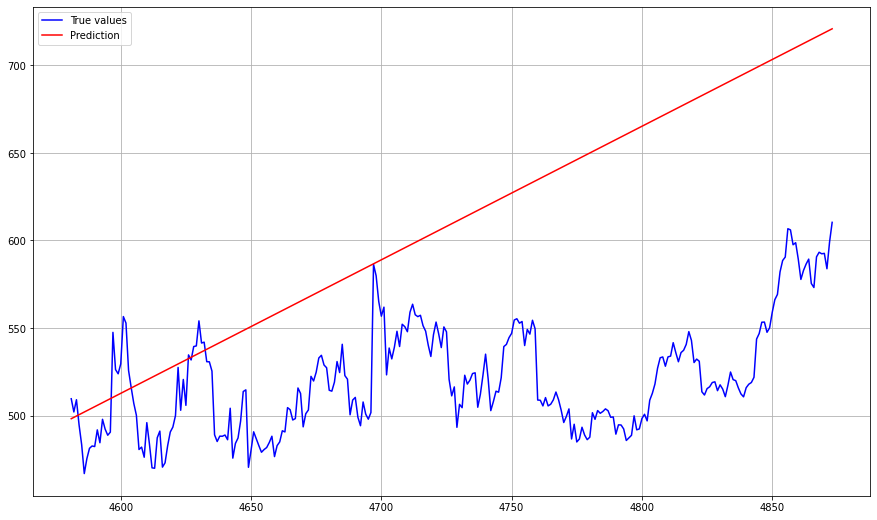

----------------
MSE(y_test, pred): 11009.153165654892


In [39]:
mini_sse = np.min(des_sse["value"])
row_sse = des_sse[des_sse["value"] == mini_sse]
method_sse, alpha_sse, beta_sse = row_sse["method"].values[0], row_sse["alpha"].values[0], row_sse["beta"].values[0]

print(f'Best parameters SSE: ({method_sse}, {alpha_sse}, {beta_sse})\nSSE: {mini_sse}')

model = Holt(y_train, initialization_method=method_sse)
fitted = model.fit(smoothing_level=alpha_sse, smoothing_trend=beta_sse)  # 0.2 / 0.42

fcast = fitted.forecast(len(y_test))

plt.figure()
plt.plot(y_test, c='blue', label='True values')
plt.plot(fcast, c='red', label='Prediction')
plt.legend()
plt.show()

print(f"----------------\nMSE(y_test, pred): {mean_squared_error(y_test, fcast)}")

### Conclusions about DES and parameters testing:
- AIC, BIC and SSE gave the same best result for DES (alpha=0.89, beta=0.1), but the predictions weren't that good (MSE value of 11009.153165654892)

- ordem: arima, rolling window, o resto
-------------

- fixar d=1 porque saca a trend 1x
- correr sarima com d=D=1 e sazonalidade=5

- usar sarima pq assim passa a ter em conta os valores passados


- alterar o codigo para fazer com os dados de teste
- tentar com vários niveis de forecast (ponto a ponto, 5 dias)
- tentar com sliding window